In [ ]:
#Importar Biblioteca
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tqdm.autonotebook import tqdm

import numpy as np #
import pandas as pd 

from keras import Sequential
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
# from keras import regularizers
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img

In [ ]:
# #Biblitoteca discord
# import discord
# import uuid
# import shutil
# from discord.ext import commands
# from decouple import config

### Análise de Dados
### 1.Problema
Existem 120 raças de cães nos dados. Temos que identificar de acordo com suas raças.
### 2.Data
Há um conjunto de treinamento e um conjunto de teste de imagens de cães. Cada imagem tem um nome de arquivo que é seu id exclusivo. O conjunto de dados compreende 120 raças de cães.
* train.zip - o conjunto de treinamento, você recebe a raça desses cães
* test.zip - o conjunto de teste, você deve prever a probabilidade de cada raça para cada imagem
* sample_submission.csv - um arquivo de envio de amostra no formato correto
* labels.csv - the breeds for the images in the train set
### Features
* Cera de 10.000 imagens pra cada.

In [ ]:
# Check GPU Processador
print("GPU", "Acessível (SIM!)" if tf.config.list_physical_devices("GPU") else "Não está Acessível :(")
tf.config.list_physical_devices("GPU")

In [ ]:
#labels csv file, show tabela
labels = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv') #arquivos
labels.head()

In [ ]:
# #descrição
# labels.describe()

In [ ]:
# #função para mostrar o comprimento da barra 'legenda'
# def barw(ax): 
    
#     for p in ax.patches:
#         val = p.get_width() #height of the bar
#         x = p.get_x()+ p.get_width() # x- position 
#         y = p.get_y() + p.get_height()/2 #y-position
#         ax.annotate(round(val,2),(x,y))
        
# #análise de quantas imagens tem por raça / dog breed

# plt.figure(figsize = (15,30))
# ax0 =sns.countplot(y=labels['breed'],order=labels['breed'].value_counts().index)
# barw(ax0)
# plt.show()

**Observação:**
1. total de 120 raças
2. pelo menos 60 imagens por categoria de raça
3. Mais amostras disponíveis -----> Mais eficiente o modelo será

In [ ]:
# Checar-se está no repositório correto/ input
from IPython.display import display, Image
Image("../input/dog-breed-identification/train/43572ba7edf772a95f539e57afd9eb43.jpg")

In [ ]:
#Teste de Repositório
import os
if len(os.listdir('/kaggle/input/dog-breed-identification/train/')) == len(labels['id']):
    print('Número de arquivo corresponde ao número de imagens')
else:
    print('Número de arquivo NÃO corresponde ao número de imagens')

In [ ]:
#Cria uma lista ordenada alfabeticamente
classes = sorted(list(set(labels['breed'])))
n_classes = len(classes)
print('Total de raças {}'.format(n_classes))

#Mapeia cada label string
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

In [ ]:
input_shape = (331,331,3)

def images_to_array(directory, label_dataframe, target_size = input_shape):
    
    image_labels = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) #dados enormes e memória ram limitada, uint8 consome menos memória
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    
    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        sizedir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
        
        dog_breed = image_labels[ix]
        y[ix] = class_to_num[dog_breed]
    
    y = to_categorical(y)
    
    return images,y

In [ ]:
import time 
t = time.time()

X,y = images_to_array('/kaggle/input/dog-breed-identification/train', labels[:])

print('runtime in seconds: {}'.format(time.time() - t))

In [ ]:
# # verificar alguns cães e suas raças
# n=25  #pega 25

# #configurar a figura
# plt.figure(figsize=(20,20))

# for i in range(n):
# #     print(i)
#     ax = plt.subplot(5, 5, i+1)
#     plt.title(classes[np.where(y[i] ==1)[0][0]])
#     plt.imshow(X[i].astype('int32')) # .astype('int32') ---> como imshow() precisa de dados inteiros para ler a imagem
    

### Criar callbacks: 
* ajudar o modelo
* ReduceLROnPlateau: reduza a taxa de aprendizado quando uma métrica parou de melhorar.

In [ ]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

#Prepare call backs
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



In [ ]:
# Hiperparâmetros
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

# Construção do Modelo
* A ideia básica aqui é extrair recursos do conjunto de dados de modelos pré-treinados e criar uma rede profunda simples usando todos esses recursos combinados.
* GlobalAveragePooling2D para extrair uma saída agrupada de nossos modelos selecionados
* img_size = Você pode alterar esta forma de acordo com a documentação do modelo pré-treinado
* Documentação Keras para todos os modelos: https://keras.io/api/applications/

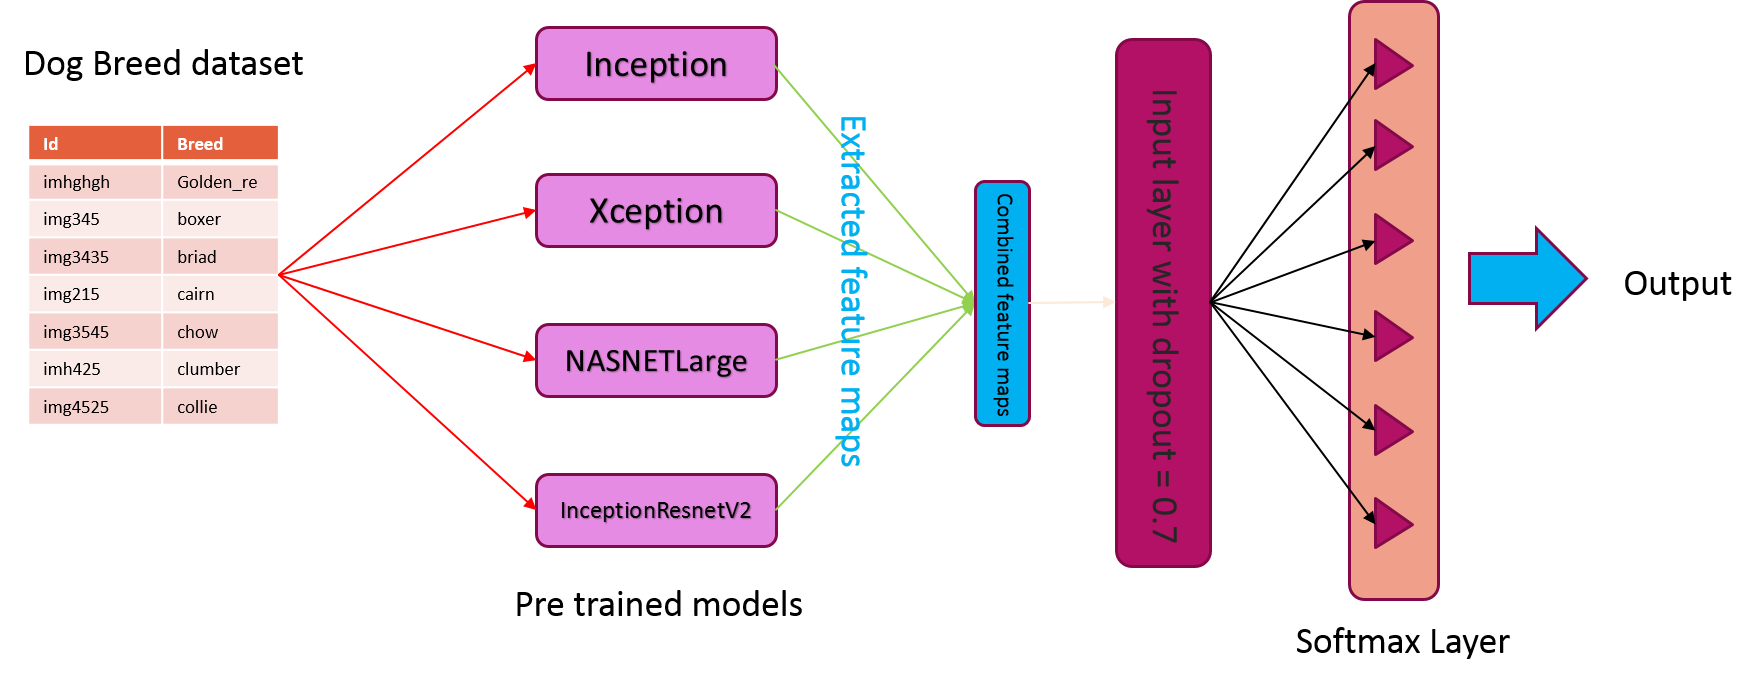

In [ ]:
#função para extrair recursos do conjunto de dados por um determinado modelo
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)  #extrair uma saída agrupada de nossos modelos selecionados
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extrair recursos:
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [ ]:
# Extrair recursos by InceptionV3 / KERAS.IO APLLICATIONS
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

In [ ]:
# Extrair recursos by Xception / KERAS.IO APLLICATIONS
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

In [ ]:
# Extrair recursos by InceptionResNetV2 / KERAS.IO APLLICATIONS
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

In [ ]:
# Extrair recursos by NASNetLarge / KERAS.IO APLLICATIONS
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, X)

In [ ]:
del X #liberar memória RAM
gc.collect()

In [ ]:
#Criando o mapa de recursos final combinando todos os recursos extraídos
final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1) #axis=-1 to concatinate horizontally

print('Forma final/ recursos finais', final_features.shape)

In [ ]:
#Preparar Deep net
model = Sequential()
# model.add(Dense(1028,input_shape=(final_features.shape[1],)))
model.add(Dropout(0.7,input_shape=(final_features.shape[1],)))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#(Train) Modelo 
history = model.fit(final_features, y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

In [ ]:
model.save('modelodog.h5') #salvar o modelo usado para o bot

In [ ]:
#Delet/ Liberar memória RAM

del inception_features
del xception_features
del nasnet_features
del inc_resnet_features
del final_features
gc.collect()

In [ ]:
sample_df = pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv') #análise

In [ ]:
sample_df.shape

In [ ]:
#ler imagens do diretório teste

def images_to_array_test(test_path, img_size = (331,331,3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    
    for ix,img_dir in enumerate(tqdm(test_filenames)):
#         img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = img_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
    print('Ouptut Data Size: ', images.shape)
    return images

test_data = images_to_array_test('/kaggle/input/dog-breed-identification/test/', img_size)

In [ ]:
#extrair
def extact_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, data)
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, data)

    final_features = np.concatenate([inception_features,
                                     xception_features,
                                     nasnet_features,
                                     inc_resnet_features],axis=-1)
    
    print('Formato final', final_features.shape)
    
    #Delet/ Liberar memória RAM
    del inception_features
    del xception_features
    del nasnet_features
    del inc_resnet_features
    gc.collect()
    
    
    return final_features

test_features = extact_features(test_data)

In [ ]:
#Liberar espaço
del test_data
gc.collect()

In [ ]:
#Prever labels test com recursos de dados de teste

pred = model.predict(test_features)

In [ ]:
# Primeira previsão
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}") #o valor de probabilidade máximo previsto pelo modelo
print(f"Sum: {np.sum(pred[0])}") # como usamos ativação softmax em nosso modelo, isso será próximo de 1
print(f"Max index: {np.argmax(pred[0])}") #o índice de onde ocorre o valor máximo em previsões[0]
print(f"Predicted label: {classes[np.argmax(pred[0])]}")

In [ ]:
# Cria DataFrame pandas com colunas vazias
preds_df = pd.DataFrame(columns=["id"] + list(classes))
preds_df.head()


In [ ]:
#Anexar IDs de imagem de teste ao DataFrame
test_path = "/kaggle/input/dog-breed-identification/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

In [ ]:
preds_df.loc[:,list(classes)]= pred

preds_df.to_csv('submission.csv',index=None)
preds_df.head()